## Working with data in HydroMT

In [3]:
import os
import sys
import matplotlib.pyplot as plt

To obtain rasterdata, we can use a HydroMT DataCatalog. There are several pre-defined DataCatalogs:
<ul> 
<li><b><i>artifact_data </i></b>: Piave basin in Northern Italy (example data) </li>
<li><b><i>deltares_data </i></b>: global datasets hosted on the p-drive</li>
<li><b><i>opendap_data (in progress ...) </i></b>: global tiled datasets hosted on the opendap server</li>
</ul> 

In [4]:
import hydromt

data_catalog = hydromt.DataCatalog(data_libs=["artifact_data"])
ds = data_catalog.get_rasterdataset("merit_hydro")

# merit hydro has multiple variables; select one
ds["elevtn"]

<xarray.DataArray 'elevtn' (y: 1920, x: 1680)>
dask.array<getitem, shape=(1920, 1680), dtype=float32, chunksize=(1920, 1680), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11.6 11.6 11.6 11.6 11.6 ... 13.0 13.0 13.0 13.0
  * y            (y) float64 46.8 46.8 46.8 46.8 46.8 ... 45.2 45.2 45.2 45.2
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    source_file:    elevtn.tif

### Often we don't need the entire extent of certain datasets, but only part of it

In [5]:
# each model can be initialized with a data_catalog
# this works similar to the data_catalog above but now we use

from hydromt_sfincs import SfincsModel

# Initialize SfincsModel with the artifact data catalog which contains data for North Italy
sf = SfincsModel(data_libs=["deltares_data"], root="tmp_example")
inp_dict = {
    "x0": 268650,
    "y0": 5018550,
    "dx": 200.0,
    "dy": 200.0,
    "nmax": 272,
    "mmax": 425,
    "rotation": 0,
    "epsg": 32633,
}
# create grid
sf.setup_grid(**inp_dict)

In [6]:
# since we already know where our model is, we minimize the amount of data that is read-in by specifying the region:

da_dep1 = sf.data_catalog.get_rasterdataset(
    "merit_hydro", variables=["elevtn"], geom=sf.region, buffer=5
)

da_dep2 = sf.data_catalog.get_rasterdataset(
    "gebco", variables=["elevtn"], geom=sf.region, buffer=5
)

### Intermezzo: We can also download the data to a local folder

In [7]:
# List of data sources to export
source_list = ["fabdem", "gebco"]
# Geographic extent
bbox = sf.region.to_crs(4326).total_bounds

folder_name = "tmp_data_export"
sf.data_catalog.export_data(
    data_root=folder_name,
    bbox=bbox,
    source_names=source_list,
    meta={"version": "1"},
)

### Local data can be added to the model as well

In [8]:
# Please specify the local geotiff you want to use:
localtiff = r"./tmp_data_export/fabdem.tif"

In [9]:
# The first option that exist is openning raster data with for example xarray:
import xarray as xr

ds_xarray = xr.open_dataset(localtiff, engine="rasterio")
ds_xarray

<xarray.Dataset>
Dimensions:      (band: 1, x: 3992, y: 1844)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 12.02 12.02 12.03 12.03 ... 13.13 13.13 13.13 13.13
  * y            (y) float64 45.79 45.79 45.79 45.79 ... 45.28 45.28 45.28 45.28
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [12]:
# The second and more elegant option is to use the data_catalog functionalities
# This also adds the data to the data_catalog, so you can use it later on in your workflow without having to specify the path again
# This also allows to keep track which data is actually used in your model (for reproducibility)
# and it has additional options to get the data for partly using bbox, region, zoom_level etc.

ds = sf.data_catalog.get_rasterdataset(
    localtiff,
    variables=["elevtn"],
    geom=sf.region,
    meta={"version": "1"},
)

# added to data_catalog
sf.data_catalog["fabdem"]

data_type: RasterDataset
driver: raster
filesystem: local
meta:
  version: '1'
path: c:\github\hydromt_sfincs\examples\tmp_data_export\fabdem.tif

### For higher-resolution datasets, sometimes making xyz-tiles is beneficial for speed 

In [13]:
fabdem = sf.data_catalog.get_rasterdataset("fabdem")

name = f"fabdem_xyz"
root = os.path.join(folder_name, name)

fabdem.raster.to_xyz_tiles(
    root=root,
    tile_size=256,
    zoom_levels=[0, 1, 2, 3],
    driver="GTiff",
    compress="deflate",
)

Tiles at zoomlevel 3 smaller than tile_size 256


### Now build a model that uses:
<ul> 
<li><b><i>local dataset </i></b>: Local download of gebco </li>
<li><b><i>data catalog xyz-tiles </i></b>: Local xyz tiles of fabdem</li>
<li><b><i>delft dashboard data (in progress)</i></b>: global tiled datasets hosted on the opendap server</li>
</ul> 

In [14]:
sf = SfincsModel(
    data_libs=["artifact_data", os.path.join(folder_name, name, f"{name}.yml")],
    root="tmp_example",
)
inp_dict = {
    "x0": 268650,
    "y0": 5018550,
    "dx": 200.0,
    "dy": 200.0,
    "nmax": 272,
    "mmax": 425,
    "rotation": 0,
    "epsg": 32633,
}
# create grid
sf.setup_grid(**inp_dict)

In [15]:
da_dep1 = sf.data_catalog.get_rasterdataset(
    "merit_hydro", variables=["elevtn"], geom=sf.region, buffer=5
)

da_dep2 = sf.data_catalog.get_rasterdataset(
    os.path.join(folder_name, "gebco.tif"),
    variables=["elevtn"],
)

# Make sure that you also load your local data_catalog if you want to use it in your model
# In this example, we only imported the fabdem_xyz.yml file, but this could be easily merged into one file to have a local data_catalog containing more datasets
da_dep3 = sf.data_catalog.get_rasterdataset(
    "fabdem_xyz", variables=["elevtn"], zoom_level=(sf.config["dx"], "meter")
)

In [16]:
# Now create the de_dep_lst. The order determines the priority of the datasets. Each dataset is a dictionary with the dataset (da) and merge_arguments
datasets_dep = [
    {"da": da_dep1, "zmin": 0.001},
    {"da": da_dep2, "offset": 0},
    {"da": da_dep3, "zmin": 0.001, "merge_method": "last"},
]

In [17]:
dep = sf.setup_dep(datasets_dep=datasets_dep)

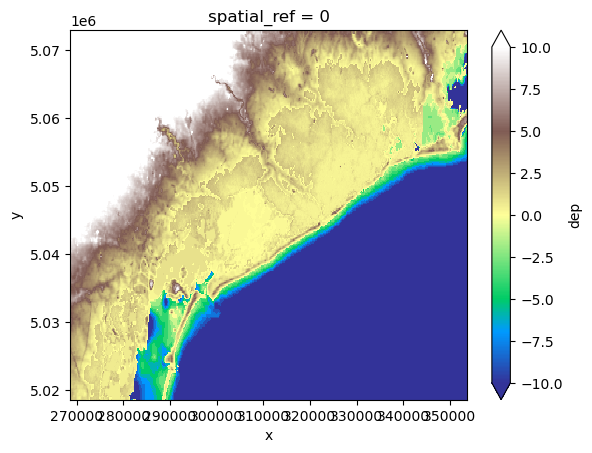

In [18]:
sf.grid["dep"].plot.imshow(vmin=-10, vmax=10, cmap="terrain")